# Intro

This project focuses on ranking hypotheses using ICE and RICE methods and conducting A/B tests. We'll analyze transactional and visit datasets to drive our decisions. These datasets form the basis for evaluating ideas and running tests to make informed choices based on real data.

In [43]:
# loading libraries
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import warnings
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

## Ranking hypoteses

### Loading and preprocessing data

In [44]:
hypotheses = pd.read_csv('data/hypotheses_us.csv', sep=';')

with pd.option_context('display.max_colwidth', None):
  display(hypotheses)

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [45]:
# adding short names to hypoteses for quick reference

short_names = [
    'channels',
    'delivery',
    'recommendation',
    'categories',
    'color',
    'reviews',
    'banners',
    'subscription',
    'birthday'
]

hypotheses.insert(1, 'short_name', short_names)

In [46]:
with pd.option_context('display.max_colwidth', None):
  display(hypotheses.loc[:, ['short_name', 'Hypothesis']])

,short_name,Hypothesis
0,channels,Add two new channels for attracting traffic. This will bring 30% more users
1,delivery,Launch your own delivery service. This will shorten delivery time
2,recommendation,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
3,categories,Change the category structure. This will increase conversion since users will find the products they want more quickly
4,color,Change the background color on the main page. This will increase user engagement
5,reviews,Add a customer review page. This will increase the number of orders
6,banners,Show banners with current offers and sales on the main page. This will boost conversion
7,subscription,Add a subscription form to all the main pages. This will help you compile a mailing list
8,birthday,Launch a promotion that gives users discounts on their birthdays


### Estimating ICE and RICE

In [47]:
# calculation of ICE and RICE scores
hypotheses['ICE'] = hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Effort']
hypotheses['RICE'] = hypotheses['Reach'] * hypotheses['ICE']
hypotheses

,Hypothesis,short_name,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,channels,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,delivery,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,recommendation,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,categories,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,color,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,reviews,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,banners,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,subscription,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,birthday,1,9,9,5,16.200000,16.2


In [48]:
# Top ICE and RICe hypoteses compared
top_hypotheses = pd.concat(
    [
        hypotheses[['short_name', 'ICE']].sort_values(by='ICE', ascending=False).reset_index(drop=True),
        hypotheses[['short_name', 'RICE']].sort_values(by='RICE', ascending=False).reset_index(drop=True)
    ],
    axis=1
)

top_hypotheses.columns = ['Top ICE hypoteses', 'ICE', 'Top RICE hypoteses', 'RICE']
top_hypotheses

,Top ICE hypoteses,ICE,Top RICE hypoteses,RICE
0,birthday,16.200000,subscription,112.0
1,channels,13.333333,recommendation,56.0
2,subscription,11.200000,channels,40.0
3,banners,8.000000,banners,40.0
4,recommendation,7.000000,birthday,16.2
5,delivery,2.000000,categories,9.0
6,reviews,1.333333,delivery,4.0
7,categories,1.125000,reviews,4.0
8,color,1.000000,color,3.0


In [49]:
# adding rank()
hypotheses['ICE_rank'] = hypotheses['ICE'].rank()
hypotheses['RICE_rank'] = hypotheses['RICE'].rank()

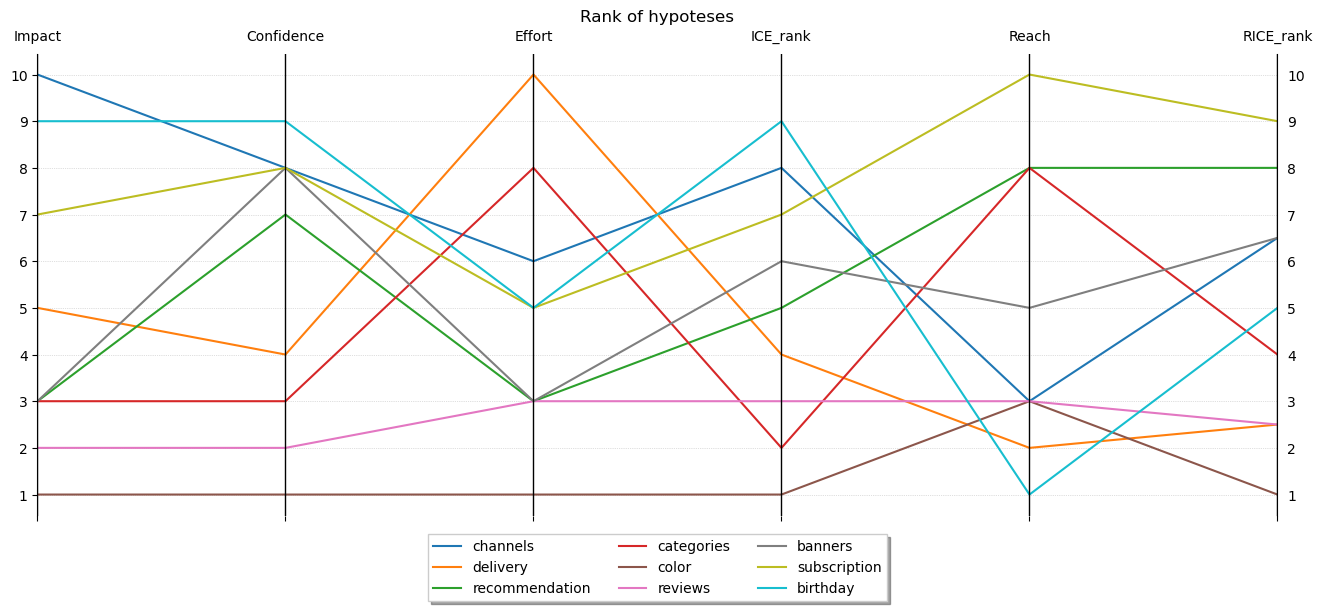

In [50]:
# plotting rank of hypoteses
fig, ax = plt.subplots(figsize=(16, 6))

pd.plotting.parallel_coordinates(hypotheses,
                                 class_column='short_name',
                                 cols=['Impact', 'Confidence', 'Effort', 'ICE_rank', 'Reach', 'RICE_rank'],
                                 ax=ax,
                                 colormap='tab10',
                                 axvlines=True,
                                 )

ax.grid(visible=True, color='grey', linestyle='dotted', linewidth=0.5, alpha=0.5)
ax.patch.set_edgecolor('white') 
plt.yticks(range(1, 11, 1))
ax.spines['top'].set_color(None)
ax.spines['bottom'].set_color(None)
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)
ax.yaxis.set_tick_params(labelright=True)
plt.title('Rank of hypoteses')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=3, fancybox=False, shadow=True)
plt.show()

### Extra: manual Parallel Coordinates Plot to visualize not ranks but the values of ICE and RICE
Source: https://stackoverflow.com/questions/8230638/parallel-coordinates-plot-in-matplotlib

In [51]:
def parallelCoordinatesPlot(title, N, data, category, ynames, colors=None, category_names=None):
    """
    A legend is added, if category_names is not None.

    :param title: The title of the plot.
    :param N: Number of data sets (i.e., lines).
    :param data: A list containing one array per parallel axis, each containing N data points.
    :param category: An array containing the category of each data set.
    :param category_names: Labels of the categories. Must have the same length as set(category).
    :param ynames: The labels of the parallel axes.
    :param colors: A colormap to use.
    :return:
    """

    fig, host = plt.subplots(figsize=(16, 6))

    # organize the data
    ys = np.dstack(data)[0]
    ymins = ys.min(axis=0)
    ymaxs = ys.max(axis=0)
    dys = ymaxs - ymins
    ymins -= dys * 0.05  # add 5% padding below and above
    ymaxs += dys * 0.05
    dys = ymaxs - ymins

    # transform all data to be compatible with the main axis
    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

    axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(ymins[i], ymaxs[i])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=14)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_top()
    host.set_title(title, fontsize=18, pad=50)

    if colors is None:
        colors = plt.cm.tab10.colors
    if category_names is not None:
        legend_handles = [None for _ in category_names]
    else:
        legend_handles = [None for _ in set(category)]
    for j in range(N):
        # to just draw straight lines between the axes:
        # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

        # create bezier curves
        # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
        #   at one third towards the next axis; the first and last axis have one less control vertex
        # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
        # y-coordinate: repeat every point three times, except the first and last only twice
        verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                         np.repeat(zs[j, :], 3)[1:-1]))
        # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=3, alpha=0.8, edgecolor=colors[category[j] - 1])
        legend_handles[category[j] - 1] = patch
        host.add_patch(patch)

        if category_names is not None:
            host.legend(category_names,
                        loc='lower center', bbox_to_anchor=(0.5, -0.18),
                        ncol=len(category_names), fancybox=False, shadow=False)

    #plt.tight_layout()
    plt.show()

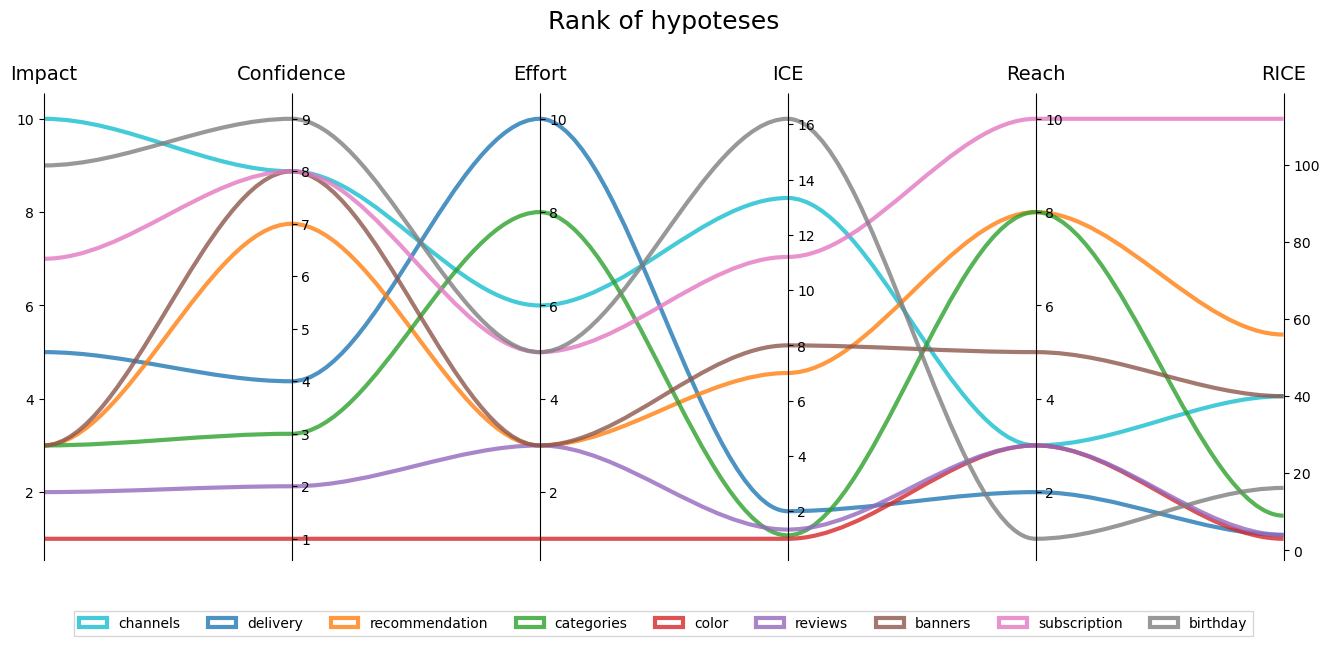

In [52]:
short_names_dict = dict((hyp, i) for i, hyp in enumerate(short_names))

yaxes = ['Impact', 'Confidence', 'Effort', 'ICE', 'Reach', 'RICE']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    parallelCoordinatesPlot(title='Rank of hypoteses',
                        N=len(hypotheses), 
                        data=[hypotheses[x] for x in yaxes],
                        category=hypotheses['short_name'].map(short_names_dict),
                        ynames=yaxes,
                        colors=None,
                        category_names=short_names_dict.keys())

### **Conclusion**

1. The top-priority hypothesis involves incorporating a subscription form across all main pages. This is due to its:
   - Above-average impact potential.
   - Well-estimated parameters.
   - Moderately manageable implementation.
   - Highest reach among identified changes.
   

2. Recommendations, while valuable due to the second-highest reach potential, estimated notably lower under Framework of RICE (56 pts vs. 112 pts)


3. Under the ICE framework, hypotheses concerning new traffic channels and promos for birthday emerge as top priorities. However, their lower reach diminishes immediate attractiveness.

## A/B Test

### Data loading and preprocessing

#### Loading

In [53]:
orders = pd.read_csv('data/orders_us.csv')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visits = pd.read_csv('data/visits_us.csv')
visits['date'] = visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)


In [54]:
display(orders.sample(5))
display(visits.sample(5))

,transactionId,visitorId,date,revenue,group
208,573486797,3118156181,2019-08-02,475.5,B
769,3257317835,1224575308,2019-08-21,10.1,A
311,3567356314,3077396270,2019-08-24,65.5,B
684,3964942202,358944393,2019-08-29,660.5,A
1124,86504917,3598591418,2019-08-13,105.3,A


,date,group,visits
23,2019-08-24,A,395
50,2019-08-20,B,560
0,2019-08-01,A,719
14,2019-08-15,A,628
40,2019-08-10,B,369


In [55]:
print('Orders info: ')
orders.info()
print('\nVisits info: ')
visits.info()

Orders info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB

Visits info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [56]:
# some summary stats
display(orders.agg({
    'date':['min', 'max', 'count', 'nunique'],
    'transactionId': ['count', 'nunique'],
    'visitorId': ['count', 'nunique'],
    'group': ['count', 'nunique'],
    'revenue': ['count', 'nunique', 'sum', 'mean', 'median', 'max', 'min']   
}).style.format('{:,.0f}', subset=['transactionId', 'visitorId', 'group', 'revenue'], na_rep=''))


display(visits.agg({
    'date':['min', 'max', 'count', 'nunique'],
    'group': ['count', 'nunique'],
    'visits': ['count', 'nunique', 'sum', 'mean', 'median', 'max', 'min']
}).style.format('{:,.0f}', subset=['group', 'visits'], na_rep=''))

,date,transactionId,visitorId,group,revenue
min,2019-08-01 00:00:00,,,,5
max,2019-08-31 00:00:00,,,,"19,920"
count,1197,"1,197","1,197","1,197","1,197"
nunique,31,"1,197","1,031",2,403
sum,nan,,,,"157,396"
mean,nan,,,,131
median,nan,,,,50


,date,group,visits
min,2019-08-01 00:00:00,,361
max,2019-08-31 00:00:00,,770
count,62,62,62
nunique,31,2,58
sum,nan,,"37,652"
mean,nan,,607
median,nan,,624


In [57]:
# match of dates and groups
set(orders.groupby(['group', 'date']).groups.keys()).difference(set(visits.groupby(['group', 'date']).groups.keys()))

set()

**Conclusion:**
- In August 2019, our A/B test covered 1197 unique transactions involving 1031 users across 37662 visits.
- The datasets contain two distinct groups, A and B, with comprehensive information on visits and transactions.
- The 'visits' dataset is aggregated, lacking specifics on individual visits for the groups.
- Both datasets encompass complete data for August 2019, without any omissions in the date-group tuples.


#### Duplicates

In [58]:
orders[orders.duplicated()]

,transactionId,visitorId,date,revenue,group


In [59]:
orders[orders[['visitorId','date','revenue']].duplicated(keep=False)]

,transactionId,visitorId,date,revenue,group
556,571224785,3941503500,2019-08-06,80.8,B
558,3621273697,3941503500,2019-08-06,80.8,B
662,1811671147,4266935830,2019-08-29,1220.2,A
682,1216533772,4266935830,2019-08-29,1220.2,B
970,3478707774,2587333274,2019-08-08,60.4,A
972,2419539947,2587333274,2019-08-08,60.4,B


In [60]:
orders[orders[['visitorId','date']].duplicated(keep=False)].sort_values('visitorId')

,transactionId,visitorId,date,revenue,group
1013,83566152,232979603,2019-08-31,5.9,A
1009,2670069237,232979603,2019-08-31,45.6,B
27,1630050528,237748145,2019-08-15,120.2,B
41,2594268419,237748145,2019-08-15,20.8,A
94,252633006,457167155,2019-08-22,95.8,B
...,...,...,...,...,...
512,2744208512,4109358064,2019-08-06,75.5,A
1019,453824282,4256040402,2019-08-31,30.5,B
1018,1415970216,4256040402,2019-08-31,80.5,A
662,1811671147,4266935830,2019-08-29,1220.2,A


In [61]:
visits[visits.duplicated()]

,date,group,visits


In [62]:
visits[visits[['date', 'group']].duplicated()]

,date,group,visits


In [63]:
orders[orders['transactionId'].duplicated()]

,transactionId,visitorId,date,revenue,group


**Conclusion:** There visitors who buy twice or more a day (and even places orders of the same size). But we can't say that these observations are wrong. So no duplicates to process.

#### Logical checks

In [64]:
# Users who placed orders both as of A and B groups
wrong_observations = orders.groupby('visitorId').filter(lambda x: x['group'].nunique() > 1).sort_values(by=['visitorId', 'date'])

print(f'{wrong_observations.visitorId.nunique()} users who have gotten into both groups A and B placed {wrong_observations.transactionId.nunique()} orders')
wrong_observations.head(10)

58 users who have gotten into both groups A and B placed 181 orders


,transactionId,visitorId,date,revenue,group
71,3679129301,8300375,2019-08-01,165.7,B
703,4293855558,8300375,2019-08-07,30.5,A
246,437656952,199603092,2019-08-02,55.7,B
1102,1941707234,199603092,2019-08-12,100.0,A
26,2223239646,199603092,2019-08-15,55.7,A
134,62794304,199603092,2019-08-22,110.3,A
823,2971973105,199603092,2019-08-27,45.9,A
1009,2670069237,232979603,2019-08-31,45.6,B
1013,83566152,232979603,2019-08-31,5.9,A
1097,3357467820,237748145,2019-08-12,10.2,A


In [65]:
# drop wrong observations
# comment to keep these observations
orders = orders.drop(wrong_observations.index)

In [66]:
# Check proportions of groups
display(orders \
        .groupby('group') \
        .agg(number_of_visitors=('visitorId', 'nunique'), 
             number_or_orders=('transactionId', 'nunique'),
             revenue=('revenue', 'sum')
            )
       )
display(visits \
        .groupby('group') \
        .agg(number_of_visits=('visits', 'sum')
            )
       )

,number_of_visitors,number_or_orders,revenue
group,,,
A,445,468,53212.0
B,528,548,79651.2


,number_of_visits
group,
A,18736
B,18916


**Conclusion:**
- dropped user of 'unclear' group
- structure of data look well balanced
- we will check outliers further as part of the project 

### Project tasks

**Preparation:** cummulative tables

In [67]:
# base table for cummulative data
dates_groups = orders[['date', 'group']].drop_duplicates()
dates_groups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [68]:
# cumulative data on orders
orders_cumm = (
    dates_groups \
    .apply(lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group']))

orders_cumm

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1
...,...,...,...,...,...
533,2019-08-29,B,510,490,74576.7
757,2019-08-30,A,460,437,52363.7
690,2019-08-30,B,531,511,77863.5
958,2019-08-31,A,468,445,53212.0


In [69]:
# cummulative data on visits

visits_cumm = (
    dates_groups \
    .apply(lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'visits': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group']))

visits_cumm

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [70]:
# full cummulative data

cumm_data = orders_cumm.merge(visits_cumm, left_on=['date', 'group'], right_on=['date', 'group'])
cumm_data.columns = [
    'date',
    'group',
    'number_of_orders',
    'number_of_visitors',
    'total_revenue',
    'number_of_visits',
]

cumm_A = cumm_data[cumm_data['group'] == 'A']
cumm_B = cumm_data[cumm_data['group'] == 'B']

cumm_data

,date,group,number_of_orders,number_of_visitors,total_revenue,number_of_visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,74576.7,17708
58,2019-08-30,A,460,437,52363.7,18037
59,2019-08-30,B,531,511,77863.5,18198
60,2019-08-31,A,468,445,53212.0,18736


#### Graph cumulative revenue by group. Make conclusions and conjectures.

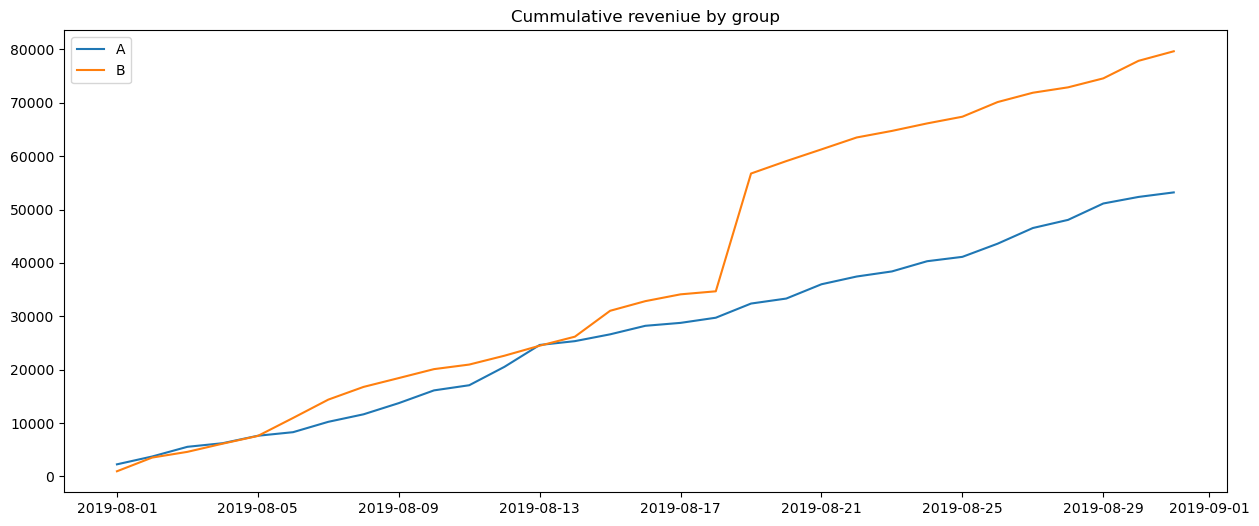

In [71]:
plt.figure(figsize=(15, 6))
plt.plot(cumm_A['date'],
         cumm_A['total_revenue'],
         label = 'A'
        )
plt.plot(cumm_B['date'],
         cumm_B['total_revenue'],
         label = 'B'
        )                                              

plt.title('Cummulative reveniue by group')
plt.legend()

**Conclusion:** Something unusual clearly occurred in the middle of the experiment within group B. It's crucial for us to explore this occurrence to gain deeper insights and understanding.

#### Graph cumulative average order size by group. Make conclusions and conjectures.

In [72]:
cumm_data['avg_order_size'] = cumm_data['total_revenue'] / cumm_data['number_of_orders']

cumm_A = cumm_data[cumm_data['group'] == 'A']
cumm_B = cumm_data[cumm_data['group'] == 'B']

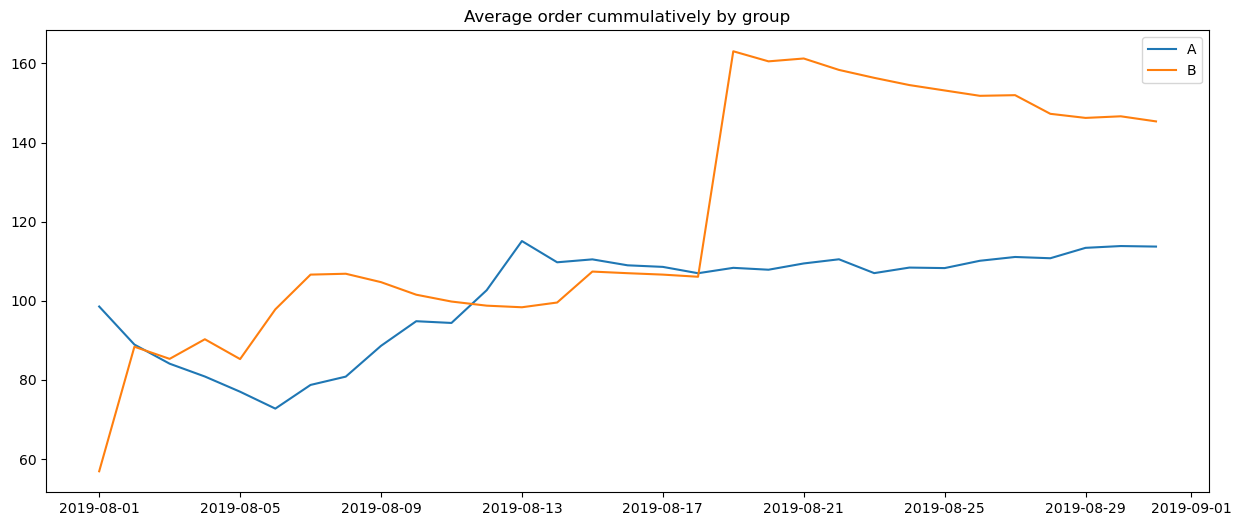

In [73]:
plt.figure(figsize=(15, 6))
plt.plot(cumm_A['date'],
         cumm_A['avg_order_size'],
         label = 'A'
        )
plt.plot(cumm_B['date'],
         cumm_B['avg_order_size'],
         label = 'B'
        )                                              

plt.title('Average order cummulatively by group')
plt.legend()

The reason behind the surge is probably in a substantial order. Just to be sure, let's examine if there's a surge in the number of orders as well.

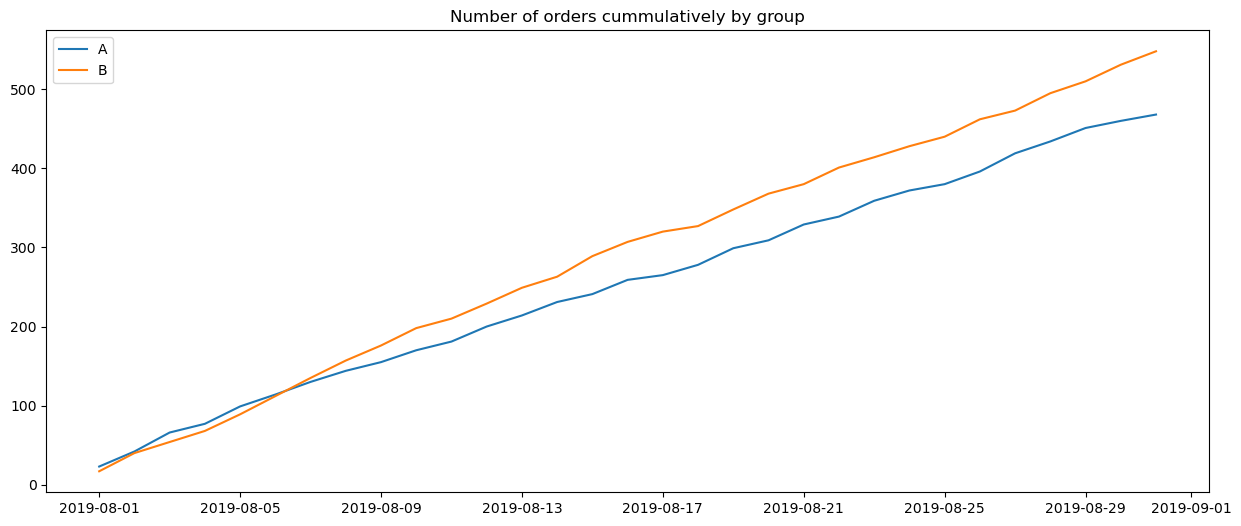

In [74]:
plt.figure(figsize=(15, 6))
plt.plot(cumm_A['date'],
         cumm_A['number_of_orders'],
         label = 'A'
        )
plt.plot(cumm_B['date'],
         cumm_B['number_of_orders'],
         label = 'B'
        )                                              

plt.title('Number of orders cummulatively by group')
plt.legend()

**Conclusion:** 
- The number of orders shows a consistent increase over time.
- Eventually, the average order size stabilizes within group A and is expected to stabilize within group B.
- We will need to handle extraordinary orders.

#### Graph the relative difference in cumulative average order size for group B compared with group A.

In [75]:
# cummulative data of A and B merged back column to column

merged_cumm_data = cumm_A.merge(cumm_B, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
merged_cumm_data = merged_cumm_data.drop(['group_A', 'group_B'], axis=1)
merged_cumm_data

,date,number_of_orders_A,number_of_visitors_A,total_revenue_A,number_of_visits_A,avg_order_size_A,number_of_orders_B,number_of_visitors_B,total_revenue_B,number_of_visits_B,avg_order_size_B
0,2019-08-01,23,19,2266.6,719,98.547826,17,17,967.2,713,56.894118
1,2019-08-02,42,36,3734.9,1338,88.926190,40,39,3535.3,1294,88.382500
2,2019-08-03,66,60,5550.1,1845,84.092424,54,53,4606.9,1803,85.312963
3,2019-08-04,77,71,6225.6,2562,80.851948,68,66,6138.5,2573,90.272059
4,2019-08-05,99,92,7623.6,3318,77.006061,89,87,7587.8,3280,85.256180
5,2019-08-06,114,104,8292.0,3985,72.736842,112,109,10957.1,3935,97.831250
6,2019-08-07,130,120,10234.0,4629,78.723077,135,132,14392.7,4644,106.612593
7,2019-08-08,144,133,11638.8,5239,80.825000,157,154,16772.6,5298,106.831847
8,2019-08-09,155,143,13734.0,5856,88.606452,176,173,18428.8,5908,104.709091
9,2019-08-10,170,158,16121.5,6262,94.832353,198,195,20103.6,6277,101.533333


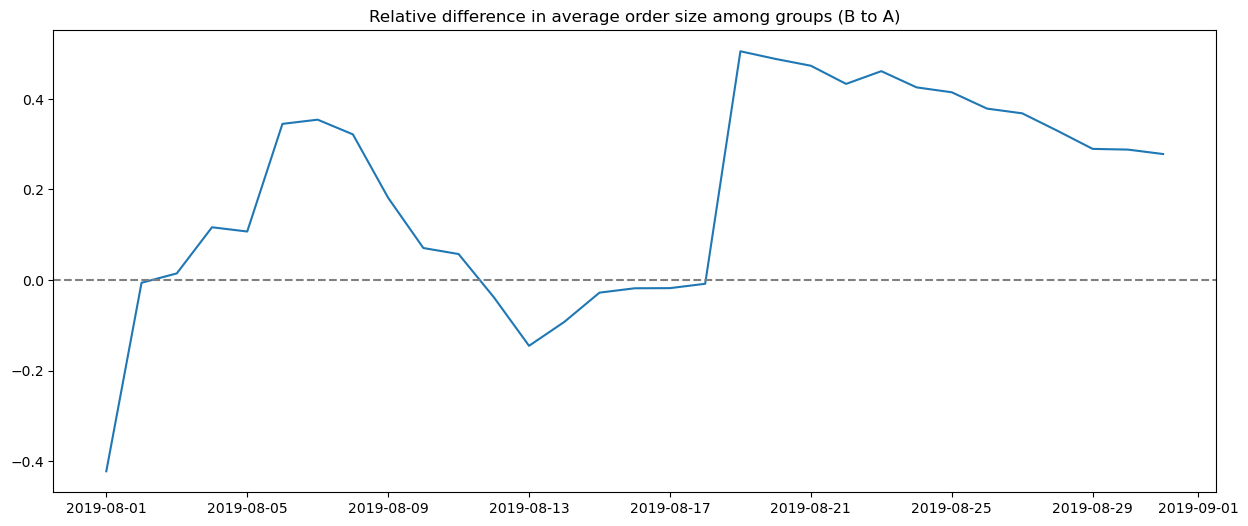

In [76]:
plt.figure(figsize=(15, 6))
plt.plot(merged_cumm_data['date'],
         merged_cumm_data['avg_order_size_B'] / merged_cumm_data['avg_order_size_A'] - 1,
         #label = 'A'
        )
plt.title('Relative difference in average order size among groups (B to A)')
plt.axhline(y=0, color='grey', linestyle='--')
# plt.legend()

**Conclusion:** 
- Early on, the variability might be because we had fewer observations.
- Some big orders popped up in the middle that we need to remove.
- After that, normal orders in group B brought the average size back to normal.

#### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. 

In [77]:
cumm_data['conversion'] = cumm_data['number_of_orders'] / cumm_data['number_of_visits']

cumm_A = cumm_data[cumm_data['group'] == 'A']
cumm_B = cumm_data[cumm_data['group'] == 'B']

In [78]:
# create daily aggregates of orders table (not cummulative)
orders_daily = (
    orders \
    .groupby(['date', 'group'], as_index=False) \
    .agg(
        number_of_orders=('transactionId', 'nunique'),
        number_of_visitors=('visitorId', 'nunique'),
        total_revenue=('revenue', 'sum')
    )
)

orders_daily

,date,group,number_of_orders,number_of_visitors,total_revenue
0,2019-08-01,A,23,19,2266.6
1,2019-08-01,B,17,17,967.2
2,2019-08-02,A,19,18,1468.3
3,2019-08-02,B,23,22,2568.1
4,2019-08-03,A,24,24,1815.2
...,...,...,...,...,...
57,2019-08-29,B,15,15,1681.2
58,2019-08-30,A,9,8,1228.9
59,2019-08-30,B,21,21,3286.8
60,2019-08-31,A,8,8,848.3


In [79]:
# create daily aggregates of visits (not cummulative)
visits_daily = (
    visits \
    .groupby(['date', 'group'], as_index=False) \
    .agg(
        number_of_visits=('visits', 'sum')
    )
)

visits_daily

,date,group,number_of_visits
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,619
3,2019-08-02,B,581
4,2019-08-03,A,507
...,...,...,...
57,2019-08-29,B,531
58,2019-08-30,A,490
59,2019-08-30,B,490
60,2019-08-31,A,699


In [80]:
# full daily data

daily_data = orders_daily.merge(visits_daily, left_on=['date', 'group'], right_on=['date', 'group'])
daily_data.columns = [
    'date',
    'group',
    'number_of_orders',
    'number_of_visitors',
    'total_revenue',
    'number_of_visits',
]

daily_data['avg_order_size'] = daily_data['total_revenue'] / daily_data['number_of_orders']
daily_data['conversion'] = daily_data['number_of_orders'] / daily_data['number_of_visits']

daily_A = daily_data[daily_data['group'] == 'A']
daily_B = daily_data[daily_data['group'] == 'B']

daily_data

,date,group,number_of_orders,number_of_visitors,total_revenue,number_of_visits,avg_order_size,conversion
0,2019-08-01,A,23,19,2266.6,719,98.547826,0.031989
1,2019-08-01,B,17,17,967.2,713,56.894118,0.023843
2,2019-08-02,A,19,18,1468.3,619,77.278947,0.030695
3,2019-08-02,B,23,22,2568.1,581,111.656522,0.039587
4,2019-08-03,A,24,24,1815.2,507,75.633333,0.047337
...,...,...,...,...,...,...,...,...
57,2019-08-29,B,15,15,1681.2,531,112.080000,0.028249
58,2019-08-30,A,9,8,1228.9,490,136.544444,0.018367
59,2019-08-30,B,21,21,3286.8,490,156.514286,0.042857
60,2019-08-31,A,8,8,848.3,699,106.037500,0.011445


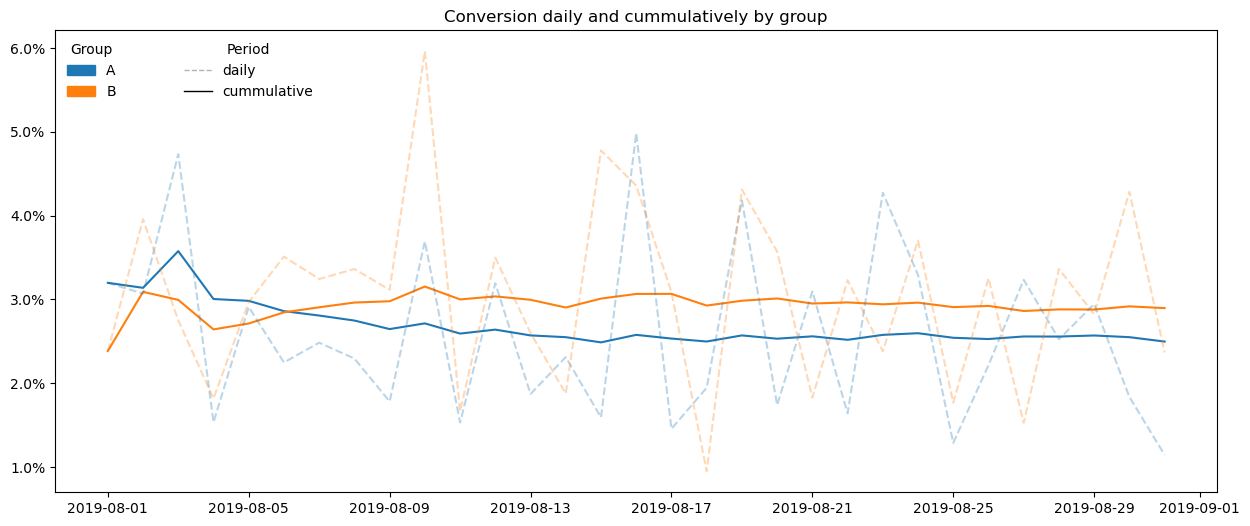

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(cumm_A['date'],
         cumm_A['conversion'],
         label = 'A'
        )
plt.plot(cumm_B['date'],
         cumm_B['conversion'],
         label = 'B'
        )                                              
plt.plot(daily_A['date'],
         daily_A['conversion'],
         label = 'A daily',
         linestyle='--',
         alpha=0.3,
         color=plt.gca().get_lines()[0].get_color()
        )        
plt.plot(daily_B['date'],
         daily_B['conversion'],
         label = 'B daily',
         linestyle='--',
         alpha=0.3,
         color=plt.gca().get_lines()[1].get_color()
        )

plt.title('Conversion daily and cummulatively by group')
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

color_legend = [
    patches.Patch(color=plt.gca().get_lines()[0].get_color(), label='A'),
    patches.Patch(color=plt.gca().get_lines()[1].get_color(), label='B'),
]

linestyle_legend = [
    Line2D([0], [0], lw=1, color="k", linestyle='--', label='daily', alpha=0.3),
    Line2D([0], [0], lw=1, color="k", linestyle='-', label='cummulative'),
]

plt.gca().add_artist(plt.legend(handles=color_legend, loc="upper left", title='Group', bbox_to_anchor=(0, 1), frameon=False))
plt.legend(handles=linestyle_legend, loc="upper left", title='Period', bbox_to_anchor=(0.1, 1), frameon=False)

**Conclusion:** 
- The daily conversion rate from visits to orders displays significant volatility, spanning from 1% to 6%. However, it stabilizes quickly around 3% on a cumulative basis.
- Group B consistently demonstrates a higher conversion rate in comparison to Group A.

#### Plot a scatter chart of the number of orders per user.

In [82]:
orders_per_user = (
    orders \
    .groupby(['visitorId', 'group'], as_index=False) \
    .agg(orders_per_user=('transactionId', 'nunique')) \
    .sort_values(['group', 'orders_per_user'])
)
orders_per_user

,visitorId,group,orders_per_user
2,11685486,A,1
6,54447517,A,1
8,66685450,A,1
11,78758296,A,1
12,85103373,A,1
...,...,...,...
897,3935952912,B,2
901,3941503500,B,2
940,4134830387,B,2
55,249864742,B,3


Text(700, 2.5, 'Group B')

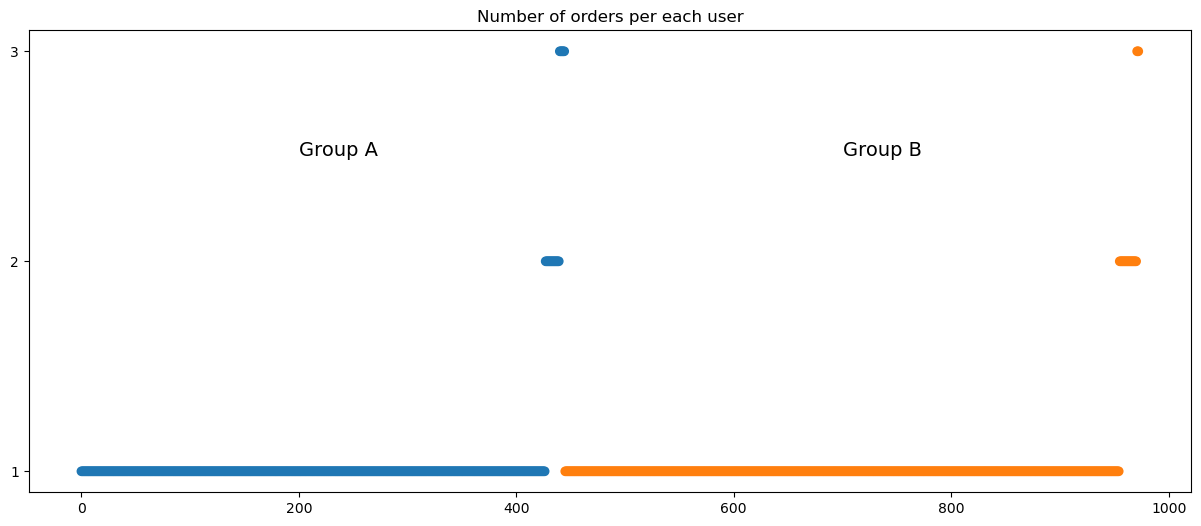

In [83]:
plt.figure(figsize=(15, 6))
plt.scatter(
    x=pd.Series(range(0, len(orders_per_user))),
    y=orders_per_user['orders_per_user'],
    c=orders_per_user['group'].map({'A':'tab:blue', 'B':'tab:orange'}),
)

plt.title('Number of orders per each user')
plt.yticks(range(1, 4, 1))
plt.gca().text(200, 2.5, 'Group A', fontsize=14)
plt.gca().text(700, 2.5, 'Group B', fontsize=14)

**Conclusion:** The number of orders per user varies from 1 to 3, with the vast majority of users making only one order. There's no apparent bias among the different user groups.

Let's check the same metric for initial dataset (before removing 'wrong' visitors

In [84]:
orders_check = pd.read_csv('data/orders_us.csv')
orders_check['date'] = orders_check['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [85]:
orders_check_per_user = (
    orders_check \
    .groupby(['visitorId', 'group'], as_index=False) \
    .agg(orders_per_user=('transactionId', 'nunique')) \
    .sort_values(['group', 'orders_per_user'])
)
orders_check_per_user

,visitorId,group,orders_per_user
2,8300375,A,1
4,11685486,A,1
8,54447517,A,1
10,66685450,A,1
13,78758296,A,1
...,...,...,...
941,3717692402,B,4
963,3803269165,B,4
1080,4256040402,B,4
596,2378935119,B,5


Text(700, 5.5, 'Group B')

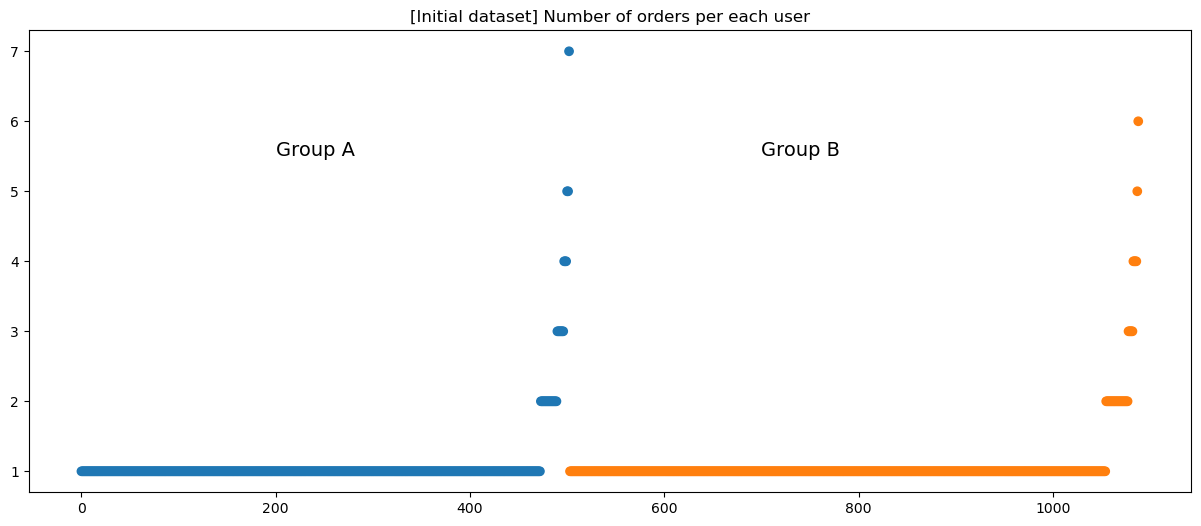

In [86]:
plt.figure(figsize=(15, 6))
plt.scatter(
    x=pd.Series(range(0, len(orders_check_per_user))),
    y=orders_check_per_user['orders_per_user'],
    c=orders_check_per_user['group'].map({'A':'tab:blue', 'B':'tab:orange'}),
)

plt.title('[Initial dataset] Number of orders per each user')
plt.gca().text(200, 5.5, 'Group A', fontsize=14)
plt.gca().text(700, 5.5, 'Group B', fontsize=14)

**Conclusion:** A few visitors who made 4 to 7 orders during the test period were initially included but have since been excluded, so there's no need for concern.

#### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [87]:
prcnt = np.percentile(orders_per_user['orders_per_user'], [95, 99])
print(f'The 95th percentile: {prcnt[0]}\nThe 99th percentile: {prcnt[1]}')

The 95th percentile: 1.0
The 99th percentile: 2.0


In [88]:
orders_per_user['orders_per_user'].value_counts(normalize=True).to_frame().style.format('{:.1%}')

,orders_per_user
1,96.3%
2,3.0%
3,0.7%


**Conclusion:** Around 96% of visitors made only one order, leading to the idea that those who made two or more orders are considered anomalies. However, it might not align with common expectations, as having two or three orders isn't typically seen as an unusual occurrence.
For this project, we'll define having 2 or more orders per visitor as abnormal behavior.

#### Plot a scatter chart of order prices.

Text(700, 15000, 'Group B')

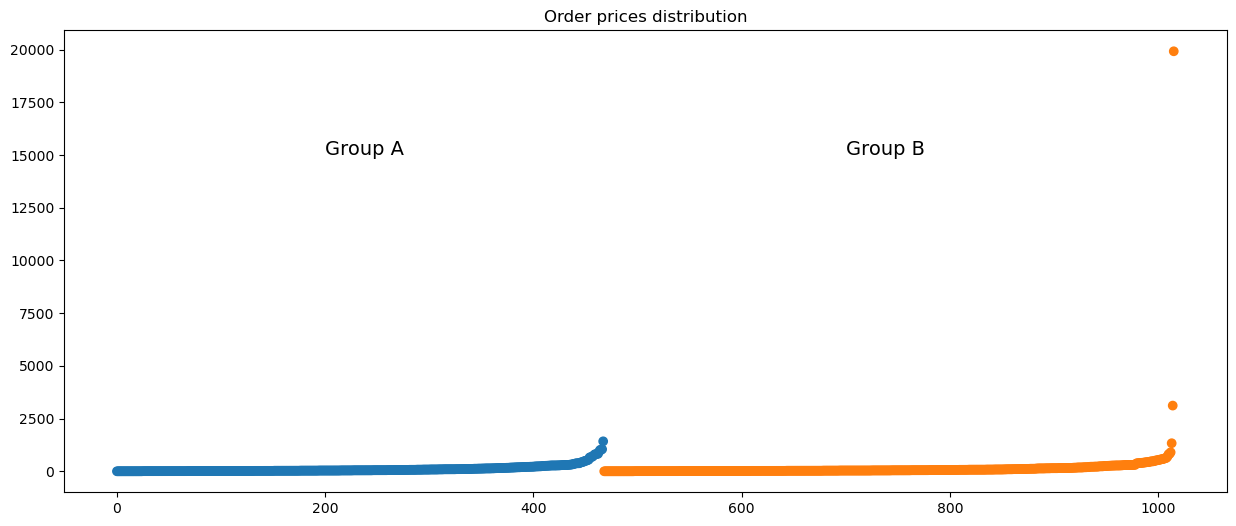

In [89]:
plt.figure(figsize=(15, 6))
plt.scatter(
    x=pd.Series(range(0, len(orders['revenue']))),
    y=orders.sort_values(['group', 'revenue']) ['revenue'],
    c=orders.sort_values(['group', 'revenue'])['group'].map({'A':'tab:blue', 'B':'tab:orange'}),
)

plt.title('Order prices distribution')
plt.gca().text(200, 15000, 'Group A', fontsize=14)
plt.gca().text(700, 15000, 'Group B', fontsize=14)

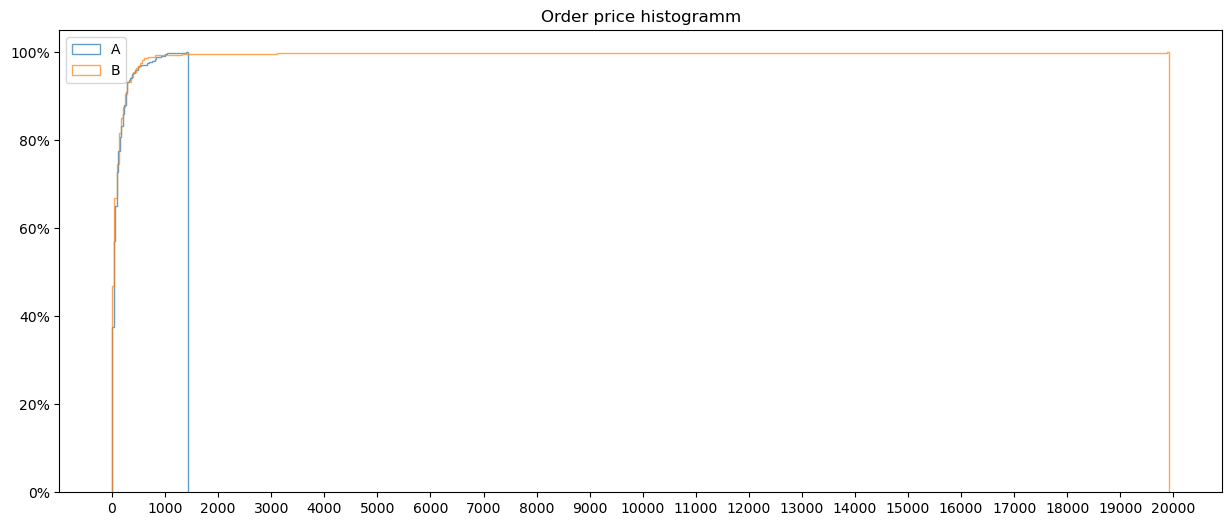

In [90]:
plt.figure(figsize=(15, 6))
plt.hist(
    x=orders[orders['group'] == 'A']['revenue'],
    density=True,
    histtype='step',
    #rwidth=0.6,
    bins=50,
    alpha=0.7,
    label='A',
    cumulative=True
)

plt.hist(
    x=orders[orders['group'] == 'B']['revenue'],
    density=True,
    histtype='step',
    #rwidth=0.6,
    bins=500,
    alpha=0.7,
    label='B',
    cumulative=True
)

plt.title('Order price histogramm')
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.xticks(range(0, 21000, 1000))
plt.legend()

**Conclusion:** There are several outliers significantly surpassing 1500 in revenue, whereas the majority of orders fall within a lower range

#### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [91]:
prcnt = np.percentile(orders['revenue'], [95, 99])
print(f'The 95th percentile: {prcnt[0]}\nThe 99th percentile: {prcnt[1]}')

The 95th percentile: 414.275
The 99th percentile: 830.3


In [92]:
orders['revenue'].value_counts(normalize=True, bins=10).to_frame().style.format('{:.1%}')

,revenue
"(-14.915999999999999, 1996.54]",99.8%
"(1996.54, 3988.08]",0.1%
"(17928.86, 19920.4]",0.1%
"(3988.08, 5979.62]",0.0%
"(5979.62, 7971.16]",0.0%
"(7971.16, 9962.7]",0.0%
"(9962.7, 11954.24]",0.0%
"(11954.24, 13945.78]",0.0%
"(13945.78, 15937.32]",0.0%
"(15937.32, 17928.86]",0.0%


In [93]:
orders['revenue'].sort_values(ascending=False).head(10)

425     19920.4
1196     3120.1
1136     1425.8
744      1335.6
743      1050.0
1103     1025.8
1099     1015.9
949       930.0
940       905.8
613       830.3
Name: revenue, dtype: float64

**Conclusion:** Orders exceeding USD 1000 will be classified as anomalies for our analysis.

#### Find the statistical significance of the difference in conversion between the groups using the raw data.

In [94]:
# level of significance
alpha = 0.05

In [95]:
# preparation to calculate conversion
number_of_orders = np.array(
    [
        daily_A['number_of_orders'].sum(),
        daily_B['number_of_orders'].sum()
    ]
)

number_of_visits = np.array(
    [
        daily_A['number_of_visits'].sum(),
        daily_B['number_of_visits'].sum()
    ]
)

In [96]:
# function that tests the hypothesis that proportions are equal

def ztest_for_2_proportions(successes, trials, alpha=0.05):
    # conversion
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 
    
    # statistic
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'p-value = {p_value:0.3f}')
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference in conversion between groups")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider conversion different between groups")
    
    return p1, p2, p2/p1, z_value, p_value 

In [97]:
conv_A, conv_B, _, _, _ = ztest_for_2_proportions(number_of_orders, number_of_visits, alpha=alpha)

print(f'Conversion of Group A from visits into orders = {conv_A:.2%}\n\
Conversion of Group B from visits into orders = {conv_B:.2%}')

p-value = 0.017
Rejecting the null hypothesis: there is a significant difference in conversion between groups
Conversion of Group A from visits into orders = 2.50%
Conversion of Group B from visits into orders = 2.90%


In [98]:
# cross-check with funcion from the statsmodels pacckage

stat, pval = proportions_ztest(number_of_orders, number_of_visits)

print(f'p-value = {pval:0.3f}')

if (pval < alpha):
    print("Rejecting the null hypothesis: there is a significant difference in conversion between groups")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider conversion different between groups") 

p-value = 0.017
Rejecting the null hypothesis: there is a significant difference in conversion between groups


#### Find the statistical significance of the difference in average order size between the groups using the raw data.

In [99]:
# mann-whitney on size of the order

pval_mw_order_size = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print(f'p-value = {pval_mw_order_size:0.3f}')
if (pval_mw_order_size < alpha):
    print("Rejecting the null hypothesis: there is a significant difference in average order size between groups")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider average order size different between groups")

p-value = 0.862
Failed to reject the null hypothesis: there is no reason to consider average order size different between groups


#### Find the statistical significance of the difference in conversion between the groups using the filtered data. 

- First, we will prepare complete set of filtered data and aggregates.
- An implied assumption is that we can only filter `orders` data and not `visits`. So that the result will be a little bit biase. In real life, we have to clean out `visits` statistics from abnormal users too.

In [100]:
# We've decided to label multiple orders per visitor as anomalies based on our previous analysis
users_multiple_orders = orders_per_user[orders_per_user['orders_per_user'] > 1]['visitorId']

# We've decided to label orders geater than 1000 as anomalies based on our previous analysis
users_oversized_orders = orders[orders['revenue']>1000]['visitorId']

abnormal_users = pd.concat([users_multiple_orders, users_oversized_orders], axis = 0).drop_duplicates()

In [101]:
orders_filtered = orders[~orders['visitorId'].isin(abnormal_users)]

In [102]:
orders_filtered_cumm = (
    dates_groups \
    .apply(lambda x: orders_filtered[
        np.logical_and(
            orders_filtered['date'] <= x['date'], orders_filtered['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group']))

orders_filtered_cumm

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,15,15,1427.4
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,30,30,2189.6
173,2019-08-02,B,37,37,3399.5
291,2019-08-03,A,54,54,4004.8
...,...,...,...,...,...
533,2019-08-29,B,469,469,47090.9
757,2019-08-30,A,415,415,42758.7
690,2019-08-30,B,490,490,50377.7
958,2019-08-31,A,423,423,43607.0


In [103]:
cumm_filtered_data = orders_filtered_cumm.merge(visits_cumm, left_on=['date', 'group'], right_on=['date', 'group'])
cumm_filtered_data.columns = [
    'date',
    'group',
    'number_of_orders',
    'number_of_visitors',
    'total_revenue',
    'number_of_visits',
]

cumm_filtered_data['avg_order_size'] = cumm_filtered_data['total_revenue'] / cumm_filtered_data['number_of_orders']
cumm_filtered_data['conversion'] = cumm_filtered_data['number_of_orders'] / cumm_filtered_data['number_of_visits']

cumm_filtered_A = cumm_filtered_data[cumm_filtered_data['group'] == 'A']
cumm_filtered_B = cumm_filtered_data[cumm_filtered_data['group'] == 'B']

cumm_filtered_data

,date,group,number_of_orders,number_of_visitors,total_revenue,number_of_visits,avg_order_size,conversion
0,2019-08-01,A,15,15,1427.4,719,95.160000,0.020862
1,2019-08-01,B,17,17,967.2,713,56.894118,0.023843
2,2019-08-02,A,30,30,2189.6,1338,72.986667,0.022422
3,2019-08-02,B,37,37,3399.5,1294,91.878378,0.028594
4,2019-08-03,A,54,54,4004.8,1845,74.162963,0.029268
...,...,...,...,...,...,...,...,...
57,2019-08-29,B,469,469,47090.9,17708,100.407036,0.026485
58,2019-08-30,A,415,415,42758.7,18037,103.033012,0.023008
59,2019-08-30,B,490,490,50377.7,18198,102.811633,0.026926
60,2019-08-31,A,423,423,43607.0,18736,103.089835,0.022577


In [104]:
merged_cumm_filtered_data = cumm_filtered_A.merge(cumm_filtered_B, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
merged_cumm_filtered_data = merged_cumm_filtered_data.drop(['group_A', 'group_B'], axis=1)

In [105]:
orders_filtered_daily = (
    orders_filtered \
    .groupby(['date', 'group'], as_index=False) \
    .agg(
        number_of_orders=('transactionId', 'nunique'),
        number_of_visitors=('visitorId', 'nunique'),
        total_revenue=('revenue', 'sum')
    )
)

orders_filtered_daily

,date,group,number_of_orders,number_of_visitors,total_revenue
0,2019-08-01,A,15,15,1427.4
1,2019-08-01,B,17,17,967.2
2,2019-08-02,A,15,15,762.2
3,2019-08-02,B,20,20,2432.3
4,2019-08-03,A,24,24,1815.2
...,...,...,...,...,...
57,2019-08-29,B,14,14,1651.1
58,2019-08-30,A,7,7,528.2
59,2019-08-30,B,21,21,3286.8
60,2019-08-31,A,8,8,848.3


In [106]:
daily_filtered_data = orders_filtered_daily.merge(visits_daily, left_on=['date', 'group'], right_on=['date', 'group'])
daily_filtered_data.columns = [
    'date',
    'group',
    'number_of_orders',
    'number_of_visitors',
    'total_revenue',
    'number_of_visits',
]

daily_filtered_data['avg_order_size'] = daily_filtered_data['total_revenue'] / daily_filtered_data['number_of_orders']
daily_filtered_data['conversion'] = daily_filtered_data['number_of_orders'] / daily_filtered_data['number_of_visits']

daily_filtered_A = daily_filtered_data[daily_filtered_data['group'] == 'A']
daily_filtered_B = daily_filtered_data[daily_filtered_data['group'] == 'B']

daily_filtered_data

,date,group,number_of_orders,number_of_visitors,total_revenue,number_of_visits,avg_order_size,conversion
0,2019-08-01,A,15,15,1427.4,719,95.160000,0.020862
1,2019-08-01,B,17,17,967.2,713,56.894118,0.023843
2,2019-08-02,A,15,15,762.2,619,50.813333,0.024233
3,2019-08-02,B,20,20,2432.3,581,121.615000,0.034423
4,2019-08-03,A,24,24,1815.2,507,75.633333,0.047337
...,...,...,...,...,...,...,...,...
57,2019-08-29,B,14,14,1651.1,531,117.935714,0.026365
58,2019-08-30,A,7,7,528.2,490,75.457143,0.014286
59,2019-08-30,B,21,21,3286.8,490,156.514286,0.042857
60,2019-08-31,A,8,8,848.3,699,106.037500,0.011445


In [107]:
orders_filtered_per_user = (
    orders_filtered \
    .groupby(['visitorId', 'group'], as_index=False) \
    .agg(orders_per_user=('transactionId', 'nunique')) \
    .sort_values(['group', 'orders_per_user'])
)
orders_filtered_per_user

,visitorId,group,orders_per_user
2,11685486,A,1
6,54447517,A,1
8,66685450,A,1
11,78758296,A,1
12,85103373,A,1
...,...,...,...
923,4251115836,B,1
924,4258103007,B,1
927,4279090005,B,1
928,4281247801,B,1


Here we ended the reproducing rockets 

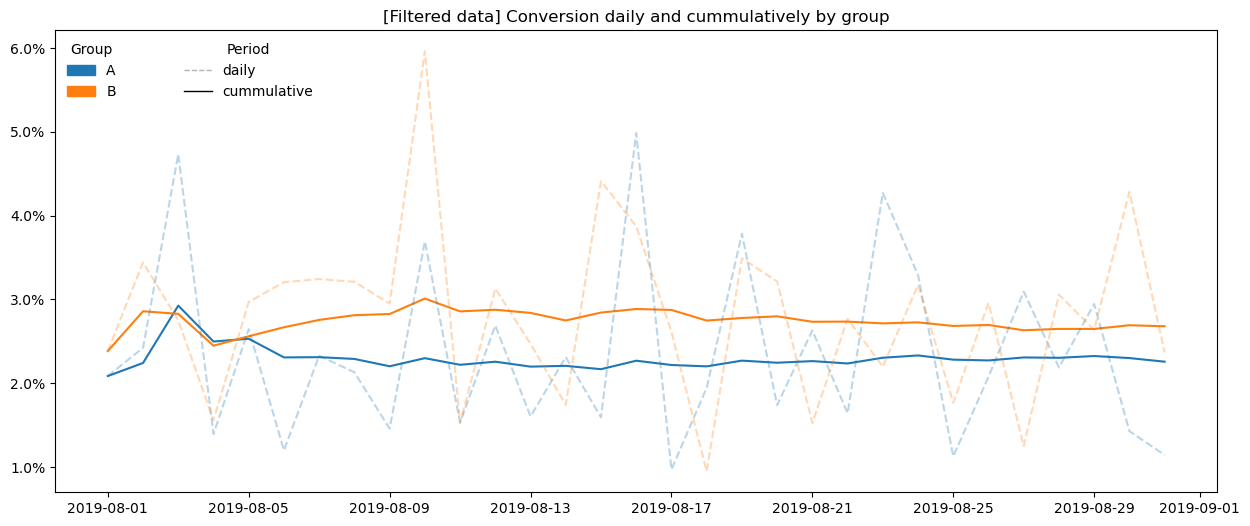

In [108]:
# plot conversion on updated data
plt.figure(figsize=(15, 6))
plt.plot(cumm_filtered_A['date'],
         cumm_filtered_A['conversion'],
         label = 'A'
        )
plt.plot(cumm_filtered_B['date'],
         cumm_filtered_B['conversion'],
         label = 'B'
        )                                              
plt.plot(daily_filtered_A['date'],
         daily_filtered_A['conversion'],
         label = 'A daily',
         linestyle='--',
         alpha=0.3,
         color=plt.gca().get_lines()[0].get_color()
        )        
plt.plot(daily_filtered_B['date'],
         daily_filtered_B['conversion'],
         label = 'B daily',
         linestyle='--',
         alpha=0.3,
         color=plt.gca().get_lines()[1].get_color()
        )

plt.title('[Filtered data] Conversion daily and cummulatively by group')
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

color_legend = [
    patches.Patch(color=plt.gca().get_lines()[0].get_color(), label='A'),
    patches.Patch(color=plt.gca().get_lines()[1].get_color(), label='B'),
]

linestyle_legend = [
    Line2D([0], [0], lw=1, color="k", linestyle='--', label='daily', alpha=0.3),
    Line2D([0], [0], lw=1, color="k", linestyle='-', label='cummulative'),
]

plt.gca().add_artist(plt.legend(handles=color_legend, loc="upper left", title='Group', bbox_to_anchor=(0, 1), frameon=False))
plt.legend(handles=linestyle_legend, loc="upper left", title='Period', bbox_to_anchor=(0.1, 1), frameon=False)

In [109]:
number_of_orders_filtered = np.array(
    [
        daily_filtered_A['number_of_orders'].sum(),
        daily_filtered_B['number_of_orders'].sum()
    ]
)

number_of_visits_filtered = np.array(
    [
        daily_filtered_A['number_of_visits'].sum(),
        daily_filtered_B['number_of_visits'].sum()
    ]
)

In [110]:
conv_A, conv_B, _, _, _ = ztest_for_2_proportions(number_of_orders_filtered, number_of_visits_filtered, alpha=alpha)

print(f'Conversion of Group A from visits into orders = {conv_A:.2%}\nConversion of Group B from visits into orders = {conv_B:.2%}')

p-value = 0.008
Rejecting the null hypothesis: there is a significant difference in conversion between groups
Conversion of Group A from visits into orders = 2.26%
Conversion of Group B from visits into orders = 2.68%


**Conclusion:**  
The difference in conversion between group A and group B remains statistically significant. On average, conversion of Group B is almost 19% higher than conversion of group A.

#### Find the statistical significance of the difference in average order size between the groups using the filtered data.

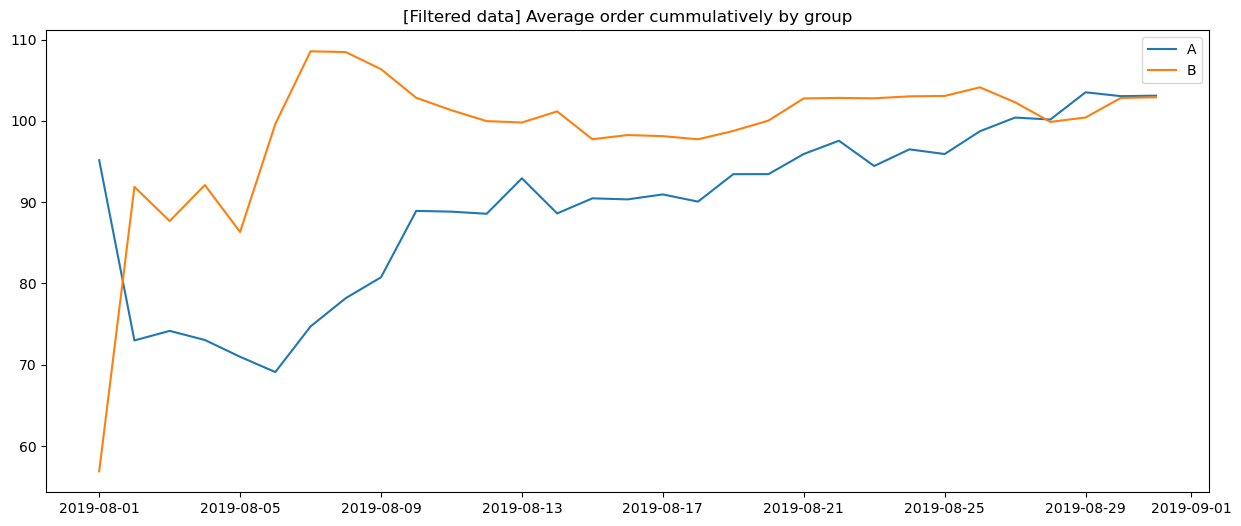

In [111]:
plt.figure(figsize=(15, 6))
plt.plot(cumm_filtered_A['date'],
         cumm_filtered_A['avg_order_size'],
         label = 'A'
        )
plt.plot(cumm_filtered_B['date'],
         cumm_filtered_B['avg_order_size'],
         label = 'B'
        )                                              

plt.title('[Filtered data] Average order cummulatively by group')
plt.legend()

In [112]:
pval_mw_order_size_filtered = st.mannwhitneyu(
    orders_filtered[orders_filtered['group']=='A']['revenue'],
    orders_filtered[orders_filtered['group']=='B']['revenue']
)[1]

print(f'p-value = {pval_mw_order_size_filtered:0.3f}')
if (pval_mw_order_size_filtered < alpha):
    print("Rejecting the null hypothesis: there is a significant difference in average order size between groups")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider average order size different between groups")

p-value = 0.996
Failed to reject the null hypothesis: there is no reason to consider average order size different between groups


**Conclusion:**
- In the end of the period the order size of Group A meets the order size of Group B. No difference.
- There's a possibility that the order size of Group A may continue to increase, whereas it appears to remain stable for Group B. However, this trend is not obvious and holds a lower probability.

#### Make a decision based on the test results. 
The possible decisions are: 
1. Stop the test, consider one of the groups the leader. 
2. Stop the test, conclude that there is no difference between the groups.
3. Continue the test.

it's advisable **to conclude the test** and declare **Group B as the leader** because:
- **Sufficient Observations**: According to [calculations](https://www.evanmiller.org/ab-testing/sample-size.html#!2.26;80;5;18.18;1), approximately 21,000 observations were needed to detect a 0.4pp difference in conversion rates from a 2.3% baseline. However, we've accumulated over 37,000 observations, surpassing the required amount.
- **Stabilized Metrics**: Key metrics like conversion rates (2.3% to 2.7%), average order per buyer (approximately one), and average order value (USD 100-110) have demonstrated stability and consistency.
- **Group B's Performance**: Group B showcases an impressive 18% higher conversion rate compared to Group A, while maintaining parity in other crucial KPIs.
